In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score

In [124]:
pwd

'a:\\Учёба\\дпп'

# Изменения

- поменять ; на , в таблице csv потому что ; - не является привыйным разделением 

In [125]:
data = pd.read_csv('cardio_train\cardio_train.csv')

In [126]:
data.head(10)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
5,8,21914,1,151,67.0,120,80,2,2,0,0,0,0
6,9,22113,1,157,93.0,130,80,3,1,0,0,1,0
7,12,22584,2,178,95.0,130,90,3,3,0,0,1,1
8,13,17668,1,158,71.0,110,70,1,1,0,0,1,0
9,14,19834,1,164,68.0,110,60,1,1,0,0,0,0


In [127]:
data.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [128]:
data['age'] = data['age'] / 365

print(data[['age']].head())


         age
0  50.391781
1  55.419178
2  51.663014
3  48.282192
4  47.873973


In [129]:
data = data[(data['ap_lo'] != 0) & (data['ap_hi'] != 0)]


id - является бесполезной колонкой - удаляем 

In [130]:
data = data.drop('id', axis=1)

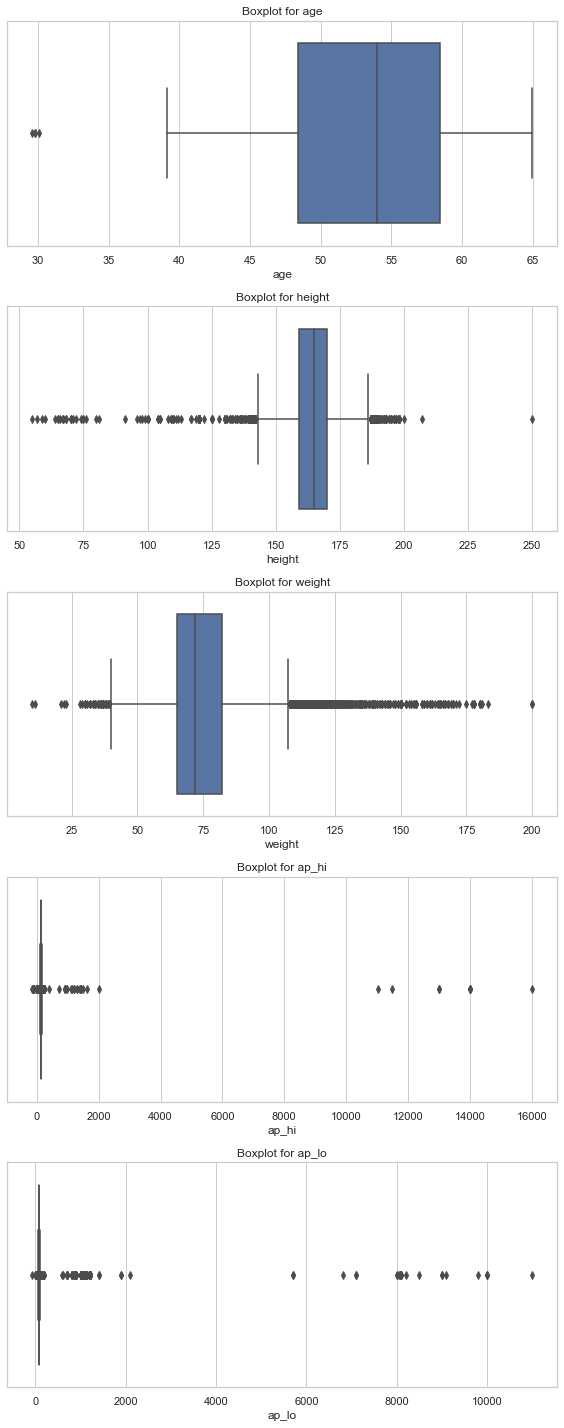

In [131]:
sns.set(style="whitegrid")

features = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(8, 4 * len(features)))

for i, feature in enumerate(features):
    sns.boxplot(x=data[feature], ax=axes[i])
    axes[i].set_title(f'Boxplot for {feature}')

plt.tight_layout()
plt.show()


In [132]:
data[data['height'] >= 200]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6486,58.136986,1,250,86.0,140,100,3,1,0,0,1,1
21628,52.202740,2,207,78.0,100,70,1,1,0,1,1,0
41901,52.567123,2,200,100.0,170,1100,2,2,0,0,1,1


In [133]:
data = data[data['height'] <= 200]

In [134]:
X = data.drop('cardio', axis=1)
y = data['cardio']

# Вычисление межквартильного размаха (IQR) для 'ap_lo'
Q1_lo = X['ap_lo'].quantile(0.25)
Q3_lo = X['ap_lo'].quantile(0.75)
IQR_lo = Q3_lo - Q1_lo

# Определение границ для выявления выбросов
lower_bound_lo = Q1_lo - 1.5 * IQR_lo
upper_bound_lo = Q3_lo + 1.5 * IQR_lo

# Выбросы для 'ap_lo'
outliers_lo = ((X['ap_lo'] < lower_bound_lo) | (X['ap_lo'] > upper_bound_lo))

Q1_hi = X['ap_hi'].quantile(0.25)
Q3_hi = X['ap_hi'].quantile(0.75)
IQR_hi = Q3_hi - Q1_hi

lower_bound_hi = Q1_hi - 1.5 * IQR_hi
upper_bound_hi = Q3_hi + 1.5 * IQR_hi

outliers_hi = ((X['ap_hi'] < lower_bound_hi) | (X['ap_hi'] > upper_bound_hi))

count_outliers_lo = outliers_lo.sum()
count_outliers_hi = outliers_hi.sum()

# Распределение cardio=0 и cardio=1 для 'ap_lo' и 'ap_hi'
distribution_lo_outliers = y[outliers_lo].value_counts().sort_index().to_frame(name='count').rename_axis('target').reset_index()
distribution_hi_outliers = y[outliers_hi].value_counts().sort_index().to_frame(name='count').rename_axis('target').reset_index()

print(f"Количество выбросов для 'ap_lo': {count_outliers_lo}")
print(f"Количество выбросов для 'ap_hi': {count_outliers_hi}")
print("\nРаспределение cardio=0 и cardio=1 для 'ap_lo':")
print(distribution_lo_outliers)
print("\nРаспределение cardio=0 и cardio=1 для 'ap_hi':")
print(distribution_hi_outliers)


Количество выбросов для 'ap_lo': 4611
Количество выбросов для 'ap_hi': 1426

Распределение cardio=0 и cardio=1 для 'ap_lo':
   target  count
0       0   2470
1       1   2141

Распределение cardio=0 и cardio=1 для 'ap_hi':
   target  count
0       0    341
1       1   1085


In [135]:
data['ap_hi'].unique()

array([  110,   140,   130,   150,   100,   120,   145,   170,   135,
         125,    90,   180,   160,   133,   190,    80,   122,   169,
         126,   158,   200,    14,   123,    70,   161,   147,   115,
         137,   153,    11,   148,   105,   220,   119,   141,   165,
         164,    12,   124,   172,   902,   162,   117,   134,   166,
         210,   176,   116,    10,   121,    16,   112,   159,   113,
         118,   155,   142,   131,   157,   136,   146,   138,  -100,
         909,   109,    85,   106,   129,    93,     7,    95,   179,
         156,   168,   132,   104,   103,   178,   175,   128,   151,
          15,   139, 11500,   127,    17,   108,   144,   102,     1,
        1420,    13,   143,   701,   107,   184,   149,   167,   114,
         101,    60,  1500,   181,   171,   202,  -115,   111,   907,
          20,   188,   185,   163,   173,   154,   177,  -140,   174,
        -120, 14020,  1400,   240,   191,   197,  1620,   152,    96,
         199,  -150,

In [136]:
def preprocess_ap_hi(ap_hi):
    if ap_hi < 0:
        ap_hi = abs(ap_hi)
    if ap_hi > 9000:
        ap_hi /= 100
    elif ap_hi > 300:
        ap_hi /= 10
    elif 1<= ap_hi <= 2:
        ap_hi *= 100
    elif 3 <= ap_hi <= 25:
        ap_hi *= 10

    return ap_hi


data['ap_hi'] = data['ap_hi'].apply(preprocess_ap_hi)

data['ap_hi'].unique()

array([110. , 140. , 130. , 150. , 100. , 120. , 145. , 170. , 135. ,
       125. ,  90. , 180. , 160. , 133. , 190. ,  80. , 122. , 169. ,
       126. , 158. , 200. , 123. ,  70. , 161. , 147. , 115. , 137. ,
       153. , 148. , 105. , 220. , 119. , 141. , 165. , 164. , 124. ,
       172. ,  90.2, 162. , 117. , 134. , 166. , 210. , 176. , 116. ,
       121. , 112. , 159. , 113. , 118. , 155. , 142. , 131. , 157. ,
       136. , 146. , 138. ,  90.9, 109. ,  85. , 106. , 129. ,  93. ,
        95. , 179. , 156. , 168. , 132. , 104. , 103. , 178. , 175. ,
       128. , 151. , 139. , 127. , 108. , 144. , 102. , 143. ,  70.1,
       107. , 184. , 149. , 167. , 114. , 101. ,  60. , 181. , 171. ,
       202. , 111. ,  90.7, 188. , 185. , 163. , 173. , 154. , 177. ,
       174. , 140.2, 240. , 191. , 197. , 152. ,  96. , 199. , 193. ,
        99. , 196. ,  40.1, 160.2, 120.2,  90.6, 230. , 207. , 215. ,
        97. , 140.9, 110.2, 130.1, 195. , 120.5, 187. ])

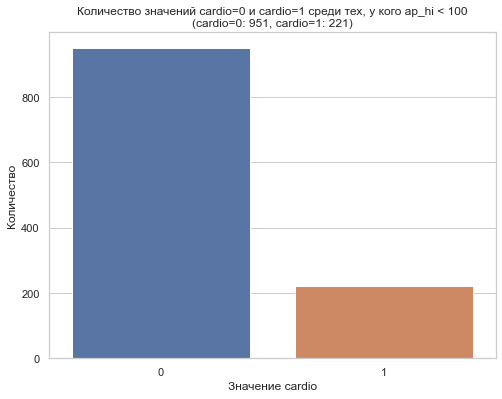

In [137]:
subset_data = data[data['ap_hi'] < 100]

count_cardio_0 = subset_data[subset_data['cardio'] == 0].shape[0]
count_cardio_1 = subset_data[subset_data['cardio'] == 1].shape[0]

plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=subset_data)
plt.title(f'Количество значений cardio=0 и cardio=1 среди тех, у кого ap_hi < 100\n(cardio=0: {count_cardio_0}, cardio=1: {count_cardio_1})')
plt.xlabel('Значение cardio')
plt.ylabel('Количество')
plt.show()


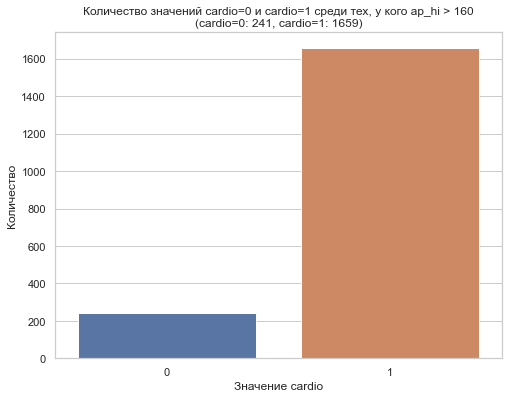

In [138]:
subset_data = data[data['ap_hi'] > 160]

count_cardio_0 = subset_data[subset_data['cardio'] == 0].shape[0]
count_cardio_1 = subset_data[subset_data['cardio'] == 1].shape[0]

plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=subset_data)
plt.title(f'Количество значений cardio=0 и cardio=1 среди тех, у кого ap_hi > 160\n(cardio=0: {count_cardio_0}, cardio=1: {count_cardio_1})')
plt.xlabel('Значение cardio')
plt.ylabel('Количество')
plt.show()


In [139]:
data['ap_lo'].unique()

array([   80,    90,    70,   100,    60,    85,    89,   110,    65,
          63,    79,  1100,  1000,   800,   120,    50,    30,   109,
          84,  1033,   150,    91,    40,    73,    78,    75,    86,
          87,  1001,    82,    95,    69,    74,    97,    81,  1200,
          83,   119,    93,   105, 10000,    99,    77,    59,  8044,
         140,    92,  1044,   108,   125,   115,    68,    61,   106,
         102,    94,    66,    52,   170,    76,   160,    62,    96,
         130,   113,    67,  9100,    10,    88,   902,     8,   112,
         104,    71,    72,  1008,    98,  2088,    20,   802,  8000,
        1022,   850,   708,    57,   101,  9011,  1011,    64,  1007,
        1177,  7100,    45,   709,  8500,    58,  1110,  8099,  1088,
         126,  1077,  1120,     7,   103,  1125,   180,   121,  8100,
         710,  5700,  8079,  1111,  1003,     6,  1900,   809,   114,
         801,  1002,    53,   111,     1,   118,    56,   182,   810,
           9,  7099,

In [140]:
def preprocess_ap_lo(ap_lo):
    if ap_lo < 0:
        ap_lo = abs(ap_lo)
    if ap_lo >= 1500:
        ap_lo /= 100
    elif 300 <= ap_lo <1500:
        ap_lo /= 10
    elif 2 <= ap_lo <= 15:
        ap_lo *= 10 
    elif ap_lo == 1:
        ap_lo *= 100

    return ap_lo
    
data['ap_lo'] = data['ap_lo'].apply(preprocess_ap_lo)



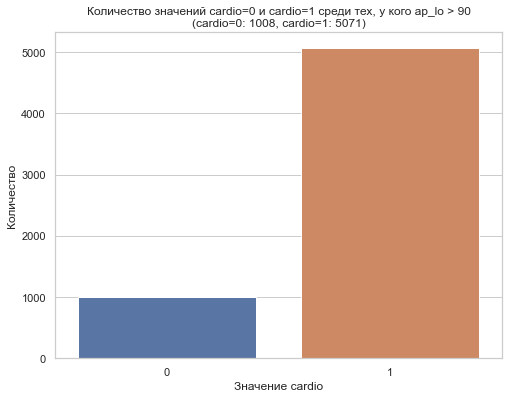

In [141]:
subset_data = data[data['ap_lo'] > 90]

count_cardio_0 = subset_data[subset_data['cardio'] == 0].shape[0]
count_cardio_1 = subset_data[subset_data['cardio'] == 1].shape[0]

plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=subset_data)
plt.title(f'Количество значений cardio=0 и cardio=1 среди тех, у кого ap_lo > 90\n(cardio=0: {count_cardio_0}, cardio=1: {count_cardio_1})')
plt.xlabel('Значение cardio')
plt.ylabel('Количество')
plt.show()


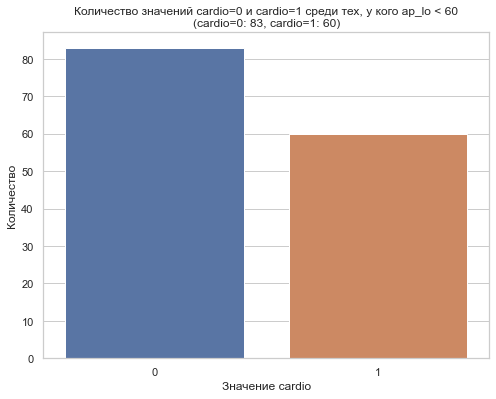

In [142]:
subset_data = data[data['ap_lo'] < 60]

count_cardio_0 = subset_data[subset_data['cardio'] == 0].shape[0]
count_cardio_1 = subset_data[subset_data['cardio'] == 1].shape[0]

plt.figure(figsize=(8, 6))
sns.countplot(x='cardio', data=subset_data)
plt.title(f'Количество значений cardio=0 и cardio=1 среди тех, у кого ap_lo < 60\n(cardio=0: {count_cardio_0}, cardio=1: {count_cardio_1})')
plt.xlabel('Значение cardio')
plt.ylabel('Количество')
plt.show()


In [143]:
def calculate_bmi(weight_kg, height_m):
    
    bmi = weight_kg / (height_m ** 2)
    return bmi

# Применение функции для создания новой колонки 'bmi'
data['bmi'] = calculate_bmi(data['weight'], data['height'] / 100)

# Вывод первых нескольких строк с новой колонкой
print(data[['weight', 'height', 'bmi']].head())


   weight  height        bmi
0    62.0     168  21.967120
1    85.0     156  34.927679
2    64.0     165  23.507805
3    82.0     169  28.710479
4    56.0     156  23.011177


In [144]:
def round_age(age):

    rounded_age = round(age)
    return rounded_age

data['age'] = data['age'].apply(round_age)


In [145]:
data[data['age'] < 39]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
6219,30,1,175,59.0,120.0,80.0,1,1,0,0,1,0,19.265306
22343,30,2,175,92.0,100.0,60.0,1,1,0,0,1,0,30.040816
30666,30,1,159,59.0,120.0,80.0,1,1,0,0,1,0,23.337684
55905,30,1,160,59.0,110.0,70.0,1,1,0,0,1,0,23.046875


In [146]:
data = data[data['age'] >= 39] 

In [147]:
data = data[data['bmi'] < 60] 

In [148]:
data[data['height'] < 110] 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
17277,48,1,98,45.0,120.0,80.0,1,1,0,0,1,0,46.855477
29735,48,1,109,64.0,140.0,80.0,3,1,0,0,1,1,53.867520
41807,64,1,109,68.0,120.0,80.0,1,1,0,0,1,1,57.234240


In [149]:
data[data['ap_lo'] >= data['ap_hi']] 

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
474,52,1,156,65.0,120.0,150.0,2,1,0,0,1,0,26.709402
636,56,2,169,68.0,70.0,110.0,1,1,0,0,1,0,23.808690
2384,64,1,154,102.0,90.0,150.0,1,1,0,0,0,1,43.008939
2990,60,2,182,90.0,80.0,140.0,3,3,0,0,1,1,27.170632
3447,55,2,180,80.0,80.0,125.0,3,3,1,1,1,1,24.691358
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66315,62,1,169,88.0,100.0,160.0,3,3,0,0,0,1,30.811246
66657,53,2,160,81.0,80.0,120.0,3,3,1,1,1,1,31.640625
67421,64,1,153,74.0,80.0,130.0,1,1,0,0,1,1,31.611773
67470,58,2,172,57.0,80.0,120.0,1,1,1,0,1,1,19.267171


In [150]:
condition = data['ap_lo'] >= data['ap_hi']

temp_ap_lo = data.loc[condition, 'ap_lo']

data.loc[condition, 'ap_lo'] = data.loc[condition, 'ap_hi']
data.loc[condition, 'ap_hi'] = temp_ap_lo

In [151]:
X = data.drop('cardio', axis=1)
y = data['cardio']

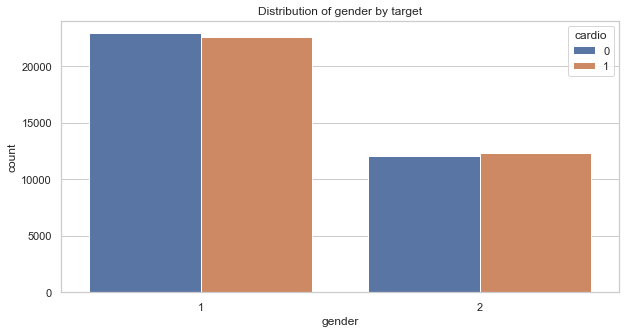

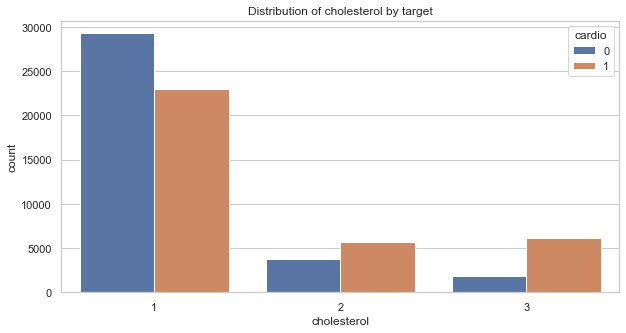

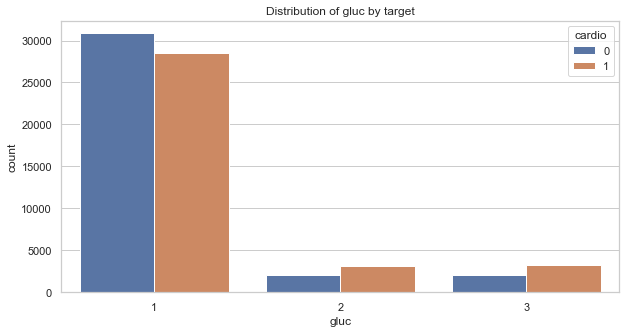

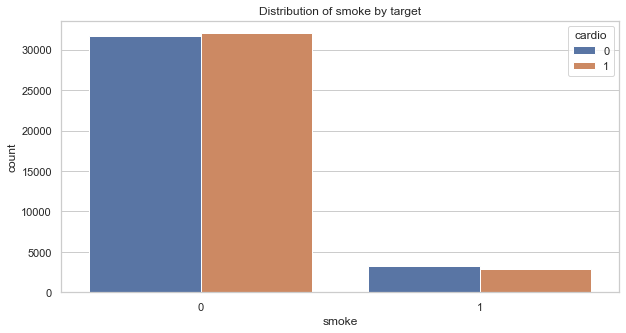

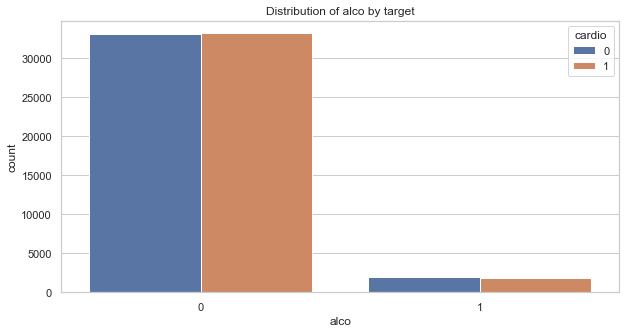

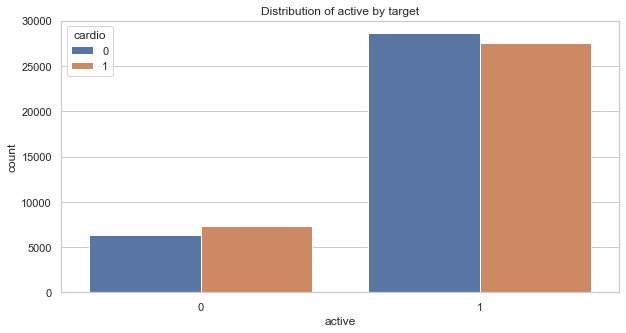

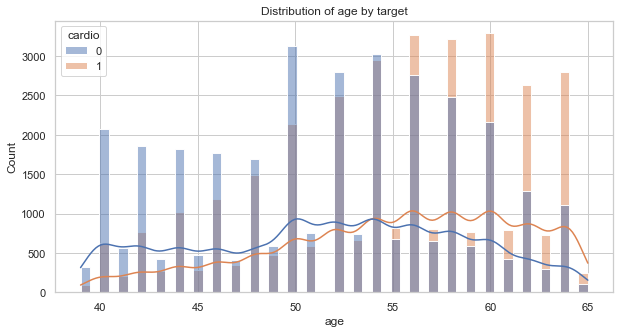

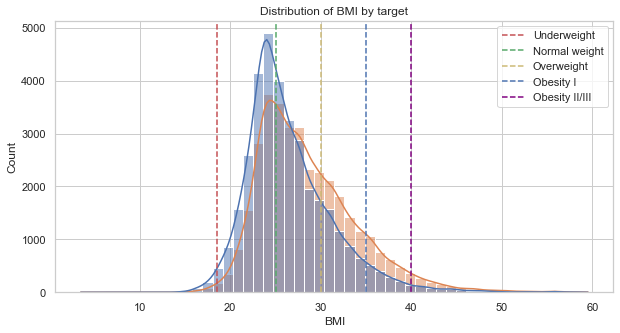

In [152]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.concat([X, y], axis=1)

for categorical_feature in ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=categorical_feature, hue='cardio', data=df)
    plt.title(f'Distribution of {categorical_feature} by target')
    plt.show()


plt.figure(figsize=(10, 5))
sns.histplot(x='age', hue='cardio', data=df, kde=True)
plt.title(f'Distribution of age by target')
plt.show()


def classify_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal weight'
    elif 25 <= bmi < 30:
        return 'Overweight'
    elif 30 <= bmi < 35:
        return 'Obesity I'
    elif 35 <= bmi < 40:
        return 'Obesity II'
    else:
        return 'Obesity III'


data['bmi_category'] = data['bmi'].apply(classify_bmi)

plt.figure(figsize=(10, 5))
sns.histplot(x='bmi', hue='cardio', data=data, kde=True, bins=50)
plt.axvline(x=18.5, color='r', linestyle='--', label='Underweight')
plt.axvline(x=25, color='g', linestyle='--', label='Normal weight')
plt.axvline(x=30, color='y', linestyle='--', label='Overweight')
plt.axvline(x=35, color='b', linestyle='--', label='Obesity I')
plt.axvline(x=40, color='purple', linestyle='--', label='Obesity II/III')
plt.title('Distribution of BMI by target')
plt.xlabel('BMI')
plt.legend()
plt.show()


In [153]:
data = data.drop(columns=['weight', 'height', 'bmi_category'])
X = data.drop('cardio', axis=1)
y = data['cardio']

In [113]:
condition_number = np.linalg.cond(data[['age','ap_hi','ap_lo', 'bmi']])

print(f"Число обусловленности данных: {condition_number:.4f}")

Число обусловленности данных: 32.4201


In [154]:
data

,age,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,110.0,80.0,1,1,0,0,1,0,21.967120
1,55,1,140.0,90.0,3,1,0,0,1,1,34.927679
2,52,1,130.0,70.0,3,1,0,0,0,1,23.507805
3,48,2,150.0,100.0,1,1,0,0,1,1,28.710479
4,48,1,100.0,60.0,1,1,0,0,0,0,23.011177
...,...,...,...,...,...,...,...,...,...,...,...
69995,53,2,120.0,80.0,1,1,1,0,1,0,26.927438
69996,62,1,140.0,90.0,2,2,0,0,1,1,50.472681
69997,52,2,180.0,90.0,3,1,0,1,0,1,31.353579
69998,61,1,135.0,80.0,1,2,0,0,0,1,27.099251


In [155]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2857, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [156]:
print(X_train.shape[0], X_valid.shape[0], X_test.shape[0])

49933 9986 9987


In [157]:
model_svm = SVC()
model_svm.fit(X_train, y_train)
y_valid_pred = model_svm.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f"SVC:\nAccuracy: {accuracy_valid:.4f}")


model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_valid_pred = model_rf.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f"RandomForestClassifier:\nAccuracy: {accuracy_valid:.4f}")


model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_valid_pred = model_knn.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f"KNeighborsClassifier:\nAccuracy: {accuracy_valid:.4f}")


model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)
y_valid_pred = model_xgb.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f"XGBClassifier:\nAccuracy: {accuracy_valid:.4f}")


catboost_model = CatBoostClassifier(random_seed=42, verbose=False, task_type="GPU")
catboost_model.fit(X_train, y_train)
y_valid_pred = catboost_model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)
print(f"CatBoostClassifier:\nAccuracy: {accuracy_valid:.4f}")

SVC:
Accuracy: 0.7280
RandomForestClassifier:
Accuracy: 0.6852
KNeighborsClassifier:
Accuracy: 0.7009
XGBClassifier:
Accuracy: 0.7355
CatBoostClassifier:
Accuracy: 0.7396


Accuracy_valid: 0.7397356298818346


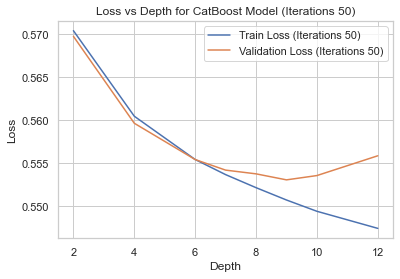

Accuracy_valid: 0.7402363308632085


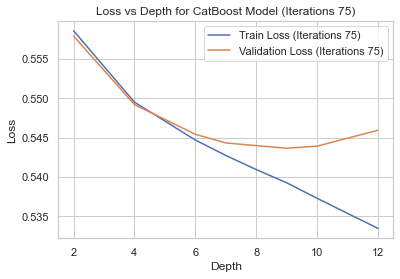

Accuracy_valid: 0.7404366112557581


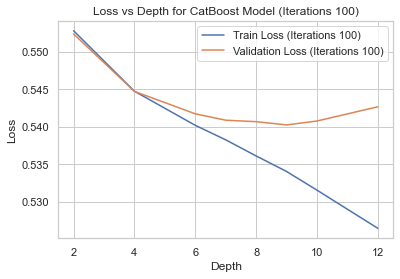

Accuracy_valid: 0.7411375926296816


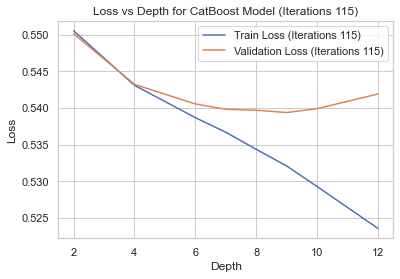

Accuracy_valid: 0.7408371720408572


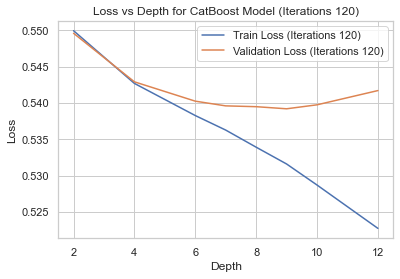

Accuracy_valid: 0.7410374524334068


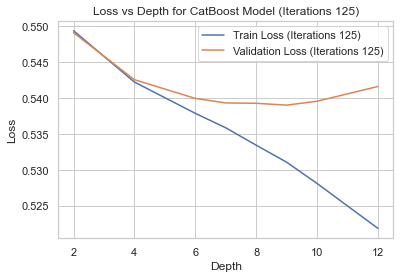

Accuracy_valid: 0.7411375926296816


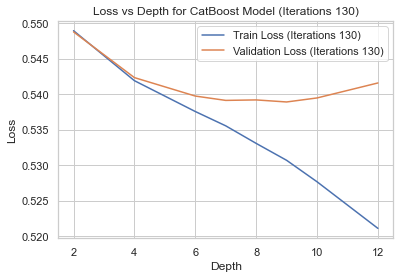

Accuracy_valid: 0.7414380132185059


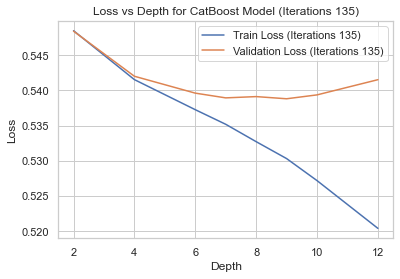

Accuracy_valid: 0.7408371720408572


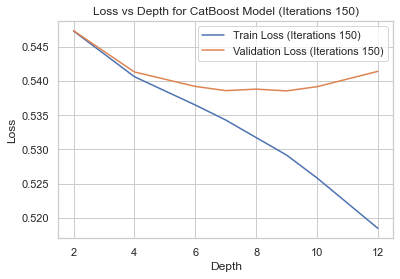

In [159]:
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, accuracy_score

depths_to_try = [2, 4, 6, 7, 8, 9, 10, 12]
iterations_to_try = [50, 75, 100, 115, 120, 125, 130, 135, 150]  

for iterations in iterations_to_try:
    best_acc = 0
    best_params = None
    train_losses = []
    valid_losses = []

    for depth in depths_to_try:
        catboost_model = CatBoostClassifier(iterations=iterations, random_strength=1, loss_function='CrossEntropy', random_seed=42, depth=depth, verbose=False, task_type="GPU")
        catboost_model.fit(X_train, y_train)

        y_train_pred_catboost = catboost_model.predict(X_train)
        y_valid_pred = catboost_model.predict(X_valid)

        loss_train = log_loss(y_train, catboost_model.predict_proba(X_train))
        loss_valid = log_loss(y_valid, catboost_model.predict_proba(X_valid))

        train_losses.append(loss_train)
        valid_losses.append(loss_valid)

        accuracy_train_catboost = accuracy_score(y_train, y_train_pred_catboost)
        accuracy = accuracy_score(y_valid, y_valid_pred)
        if best_acc <= accuracy:
            best_acc = accuracy
            best_params = [iterations, depth]


    print(f"Accuracy_valid: {best_acc}")

    plt.plot(depths_to_try, train_losses, label=f'Train Loss (Iterations {iterations})')
    plt.plot(depths_to_try, valid_losses, label=f'Validation Loss (Iterations {iterations})')

    plt.xlabel('Depth')
    plt.ylabel('Loss')
    plt.title(f'Loss vs Depth for CatBoost Model (Iterations {iterations})')
    plt.legend()
    plt.show()


In [174]:
catboost_model = CatBoostClassifier(iterations= 135, loss_function= 'CrossEntropy', depth=6, verbose=False, task_type="GPU")
catboost_model.fit(X_train, y_train)

y_train_pred = catboost_model.predict(X_train)
accuracy_train = accuracy_score(y_train, y_train_pred)

y_valid_pred = catboost_model.predict(X_valid)
accuracy_valid = accuracy_score(y_valid, y_valid_pred)

y_test_pred = catboost_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)

conf_matrix_train = confusion_matrix(y_test, y_test_pred)
classification_rep_train = classification_report(y_test, y_test_pred)

print(f"Train Accuracy - {accuracy_train:.4f} - Validation Accuracy: {accuracy_valid:.4f}   - Test Accuracy: {accuracy_test:.4f} ")


print(f"\n{conf_matrix_train}\n{classification_rep_train}")

feature_importance = catboost_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)



Train Accuracy - 0.7378 - Validation Accuracy: 0.7405   - Test Accuracy: 0.7319 

[[3822 1090]
 [1588 3487]]
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      4912
           1       0.76      0.69      0.72      5075

    accuracy                           0.73      9987
   macro avg       0.73      0.73      0.73      9987
weighted avg       0.73      0.73      0.73      9987

       Feature  Importance
2        ap_hi   45.543732
0          age   22.245122
4  cholesterol   15.137463
9          bmi    5.894749
3        ap_lo    4.326936
5         gluc    2.412894
8       active    2.182752
6        smoke    1.251116
7         alco    0.629863
1       gender    0.375374


1. **Метрики точности (Accuracy):**
   - **Train Accuracy (Точность на обучающем наборе):** 73.78%
   - **Validation Accuracy (Точность на валидационном наборе):** 74.05%
   - **Test Accuracy (Точность на тестовом наборе):** 73.19%

2. **Матрица ошибок (Confusion Matrix):**
   ```
   [[3822 (True Negative)   1090 (False Positive)]
    [1588 (False Negative)   3487 (True Positive)]]
   ```
   - **True Negative (TN):** 3822
   - **False Positive (FP):** 1090
   - **False Negative (FN):** 1588
   - **True Positive (TP):** 3487

3. **Метрики классификации:**
   - **Precision (Точность):** Для класса 0 (отсутствие болезни) точность составляет 71%, а для класса 1 (присутствие болезни) - 76%.
   - **Recall (Полнота):** Доля правильно предсказанных положительных среди всех реальных положительных. Для класса 0 полнота составляет 78%, а для класса 1 - 69%.
   - **F1-score (F1-мера):** Среднее гармоническое между точностью и полнотой. Для класса 0 F1-мера равна 0.74, а для класса 1 - 0.72.
   - **Support (Общее количество элементов в каждом классе):** 4912 для класса 0, 5075 для класса 1.
   - **Accuracy (Общая точность):** 73% (как указано выше).

4. **Важность признаков:**
   - "ap_hi" (верхнее артериальное давление) считается самым важным признаком с важностью 45.54%, затем идут "age" (возраст) с 22.25% и "cholesterol" (уровень холестерина) с 15.14%.


In [216]:
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

catboost_model = CatBoostClassifier(
    iterations=135,
    loss_function='CrossEntropy',
    depth=6,
    verbose=False,
    task_type="GPU"
)

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

cross_val_results = cross_val_score(catboost_model, X, y, cv=cv, scoring='accuracy')

print("Accuracy по каждому фолду:", cross_val_results)
print("Средняя accuracy:", cross_val_results.mean())


Accuracy по каждому фолду: [0.73588306 0.74369243 0.72226672 0.73522932 0.7426397  0.73943521
 0.7354296  0.73823353 0.72401362 0.73382736]
Средняя accuracy: 0.7350650542317113


In [269]:
catboost_model = CatBoostClassifier(iterations= 135, loss_function= 'CrossEntropy', depth=6, verbose=False, task_type="GPU")
catboost_model.fit(X, y)

y_pred = catboost_model.predict(X)
accuracy = accuracy_score(y, y_pred)

conf_matrix_train = confusion_matrix(y, y_pred)
classification_rep_train = classification_report(y, y_pred)

print(f"Accuracy - {accuracy:.4f}  ")


print(f"\n{conf_matrix_train}\n{classification_rep_train}")

feature_importance = catboost_model.feature_importances_


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)



Accuracy - 0.7375  

[[27255  7712]
 [10638 24301]]
              precision    recall  f1-score   support

           0       0.72      0.78      0.75     34967
           1       0.76      0.70      0.73     34939

    accuracy                           0.74     69906
   macro avg       0.74      0.74      0.74     69906
weighted avg       0.74      0.74      0.74     69906

       Feature  Importance
2        ap_hi   45.819612
0          age   22.062597
4  cholesterol   15.990182
9          bmi    5.492468
3        ap_lo    3.911483
5         gluc    2.489396
8       active    2.108120
6        smoke    0.925730
7         alco    0.673401
1       gender    0.527012


In [228]:
catboost_model.save_model('catboost_iterations_135_depth_6') 

In [229]:
model = CatBoostClassifier() 
model.load_model('catboost_iterations_135_depth_6')

In [268]:
import pandas as pd

fn_data = pd.DataFrame({
    'age': [50],
    'gender': [1],
    'ap_hi': [120],
    'ap_lo': [66],
    'cholesterol': [2],
    'gluc': [1],
    'smoke': [1],
    'alco': [0],
    'active': [0],
    'bmi': [55],
})

print(fn_data.head())

pred = catboost_model.predict(fn_data)
pred[0]

   age  gender  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  bmi
0   50       1    120     66            2     1      1     0       0   55


0